# Compare theory predictions using Nyx / Gadget emulators

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140

In [2]:
# our modules
from lace_manager.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace_manager.emulator import p1d_archive_Nyx
from lace_manager.likelihood import full_theory

### Setup mock data from central Gadget sim

In [3]:
# specify simulation suite and P1D mesurements
basedir="lace/emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_min=2.95
z_max=3.55
emu_type="polyfit"
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label="central",
                                zmin=z_min,zmax=z_max,
                                polyfit=(emu_type=="polyfit"))
print('mock data will have only z =',data.z)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00
mock data will have only z = [3.   3.25 3.5 ]


3.0
3.25
3.5


(0.005, 0.6)

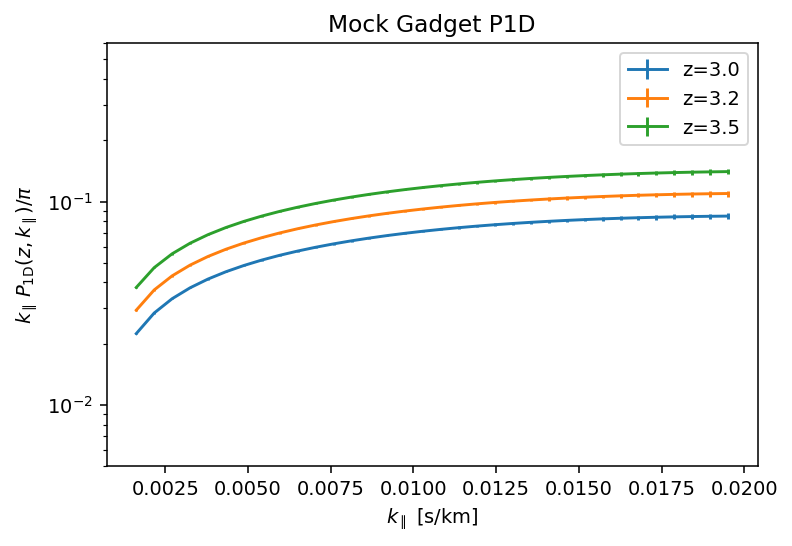

In [4]:
k_kms=data.k
for iz,z in enumerate(data.z):
    print(z)
    Pk_kms=data.get_Pk_iz(iz)
    cov_kms=data.get_cov_iz(iz)
    plt.errorbar(k_kms,Pk_kms*k_kms/np.pi,yerr=np.sqrt(np.diag(cov_kms))*k_kms/np.pi,label='z=%.1f'%z)
        
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k_\parallel$ [s/km]')
plt.ylabel(r'$k_\parallel \, P_{\rm 1D}(z,k_\parallel) / \pi$')
plt.title('Mock Gadget P1D')
plt.ylim(0.005,0.6)

### Setup archive and emulator parameters from Gadget sims

In [5]:
# let's use the same pivot point for both
kp_Mpc=0.7

In [6]:
gadget={'label':'Gadget'}
# archive of simulated P1D measurements
gadget['archive']=p1d_archive.archiveP1D(basedir=basedir,skewers_label=skewers_label,
                            drop_tau_rescalings=True,z_max=4.0,kp_Mpc=kp_Mpc)
# specify parameters to be used in emulator
gadget['paramList']=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
gadget['kmax_Mpc']=8

### Setup archive and emulator parameters from Nyx sims

In [7]:
nyx={'label':'Nyx'}
# archive of simulated P1D measurements
nyx_fname='/Users/font/Projects/LaCE_manager/lace_manager/emulator/sim_suites/test_nyx/large_nyx_models.hdf5'
#nyx_fname='/Users/font/Projects/LaCE_manager/lace_manager/emulator/sim_suites/test_nyx/models.hdf5'
nyx['archive']=p1d_archive_Nyx.archiveP1D_Nyx(fname=nyx_fname,kp_Mpc=kp_Mpc,verbosity=1)
# specify parameters to be used in emulator
nyx['paramList']=['mF', 'sigT_Mpc', 'gamma', 'Delta2_p', 'n_p']
# specify k range
nyx['kmax_Mpc']=8

will read Nyx file /Users/font/Projects/LaCE_manager/lace_manager/emulator/sim_suites/test_nyx/large_nyx_models.hdf5
number of samples 14
parameter names ['A_UVB', 'A_lya', 'A_s', 'H_0', 'Omega_m', 'h', 'n_lya', 'n_s', 'omega_m', 'sigma8']
will use redshift grid [2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 5.0, 5.4]
thermal grid ['thermal_grid_0', 'thermal_grid_1', 'thermal_grid_10', 'thermal_grid_11', 'thermal_grid_12', 'thermal_grid_13', 'thermal_grid_14', 'thermal_grid_2', 'thermal_grid_3', 'thermal_grid_4', 'thermal_grid_5', 'thermal_grid_6', 'thermal_grid_7', 'thermal_grid_8', 'thermal_grid_9']
archive setup, containing 3150 entries


### Setup both emulators and theories

In [8]:
for suite in [gadget,nyx]:
    suite['emulator']=gp_emulator.GPEmulator(paramList=suite['paramList'],
                                passarchive=suite['archive'],
                                kmax_Mpc=suite['kmax_Mpc'],
                                emu_type=emu_type,
                                train=True)

Training GP on 270 points


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 0.38 seconds
Training GP on 3150 points
GPs optimised in 100.18 seconds


In [9]:
for suite in [gadget,nyx]:
    suite['theory']=full_theory.FullTheory(zs=data.z,emulator=suite['emulator'],verbose=False)
    suite['prediction']=suite['theory'].get_p1d_kms(k_kms=k_kms,like_params=[],
                                                    return_covar=True,return_blob=False)

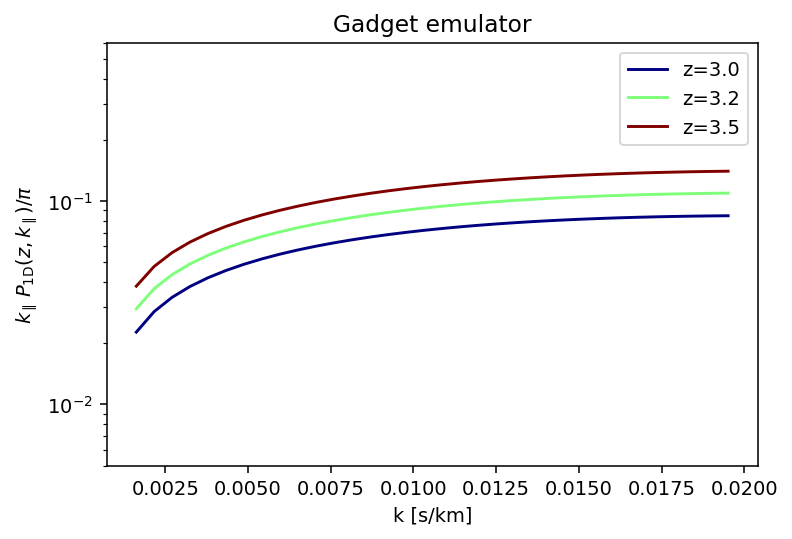

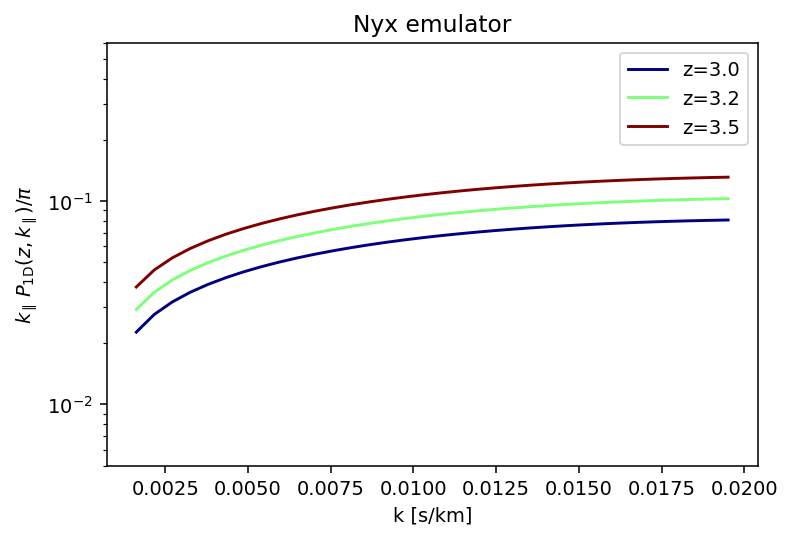

In [10]:
for suite in [gadget,nyx]:
    plt.figure()
    plt.title('{} emulator'.format(suite['label']))
    suite['theory'].plot_p1d(k_kms,like_params=[])
    plt.show()

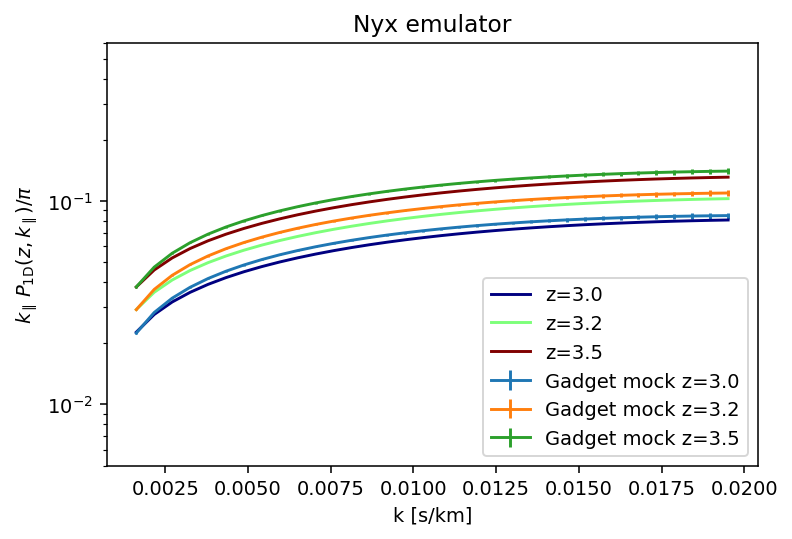

In [11]:
for iz,z in enumerate(data.z):
    Pk_kms=data.get_Pk_iz(iz)
    cov_kms=data.get_cov_iz(iz)
    plt.errorbar(k_kms,Pk_kms*k_kms/np.pi,yerr=np.sqrt(np.diag(cov_kms))*k_kms/np.pi,label='Gadget mock z=%.1f'%z)
for suite in [nyx]:
    #plt.figure()
    plt.title('{} emulator'.format(suite['label']))
    suite['theory'].plot_p1d(k_kms,like_params=[])
#    plt.show()